In [100]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 加载数据

In [101]:
data = pd.read_csv('zgpa_train.csv')
price = data['close']

# 归一化价格数据

In [102]:
price_norm = price / price.max()

In [103]:

print(price_norm)

0      0.383273
1      0.389266
2      0.389666
3      0.379545
4      0.381808
         ...   
726    0.751099
727    0.750566
728    0.738447
729    0.733120
730    0.722466
Name: close, Length: 731, dtype: float64


# 可视化原始价格数据

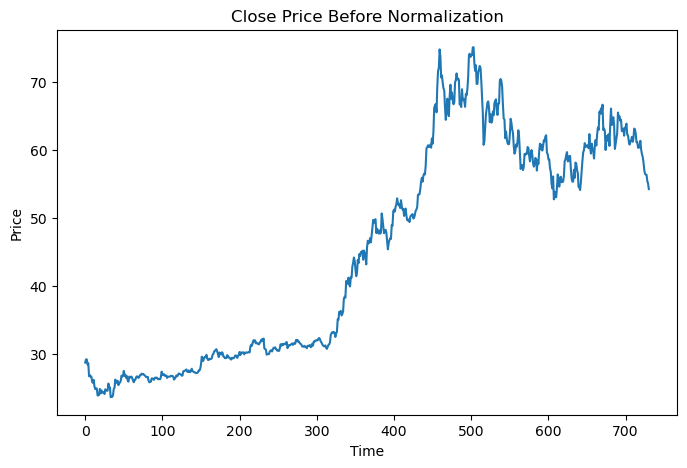

In [104]:
plt.figure(figsize=(8,5))
plt.plot(price)
plt.title('Close Price Before Normalization')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# 为模型提取数据

In [105]:
def extract_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step].to_numpy())
        y.append(data[i+time_step])
    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# 数据集

In [106]:
time_step = 8
X, y = extract_data(price_norm, time_step)

# 建立模型

In [107]:
class SimpleRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, h = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

# 损失函数和优化器

In [108]:
model = SimpleRNNModel(1, 5, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 数据

In [109]:
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=30, shuffle=True)

# 训练模型

In [110]:
num_epochs = 200
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

# 在训练数据上进行预测

In [111]:
model.eval()
with torch.no_grad():
    y_train_pred = model(X) * price.max()

# 可视化训练数据的预测结果

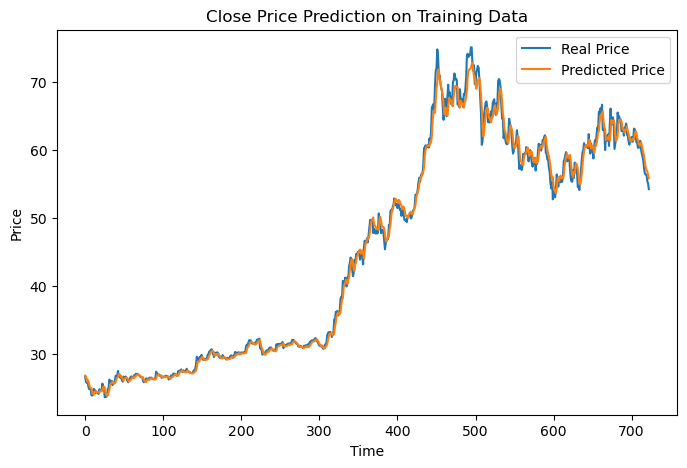

In [112]:
plt.figure(figsize=(8, 5))
plt.plot(y.numpy() * price.max(), label='Real Price')
plt.plot(y_train_pred.numpy(), label='Predicted Price')
plt.title('Close Price Prediction on Training Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

# 加载和预处理测试数据

In [114]:
data_test = pd.read_csv('zgpa_test.csv')
price_test = data_test['close']
price_test_norm = price_test / price.max()
X_test, y_test = extract_data(price_test_norm, time_step)

# 在测试数据上进行预测

In [115]:
X_test = X_test.to(torch.float32)
y_test_pred = model(X_test) * price.max()


# 可视化测试数据的预测结果

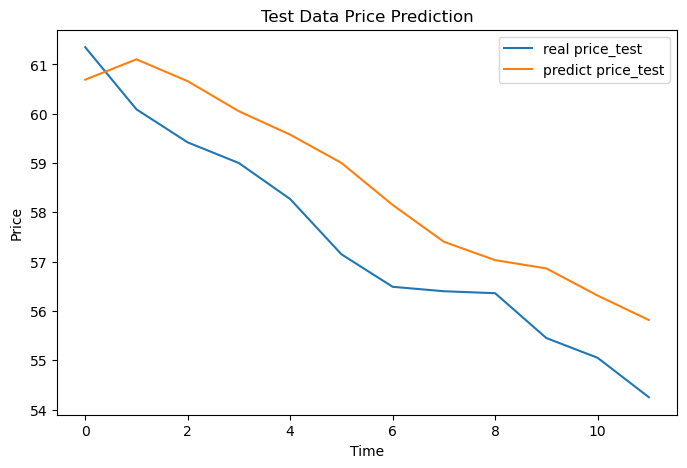

In [116]:
plt.figure(figsize=(8, 5))

plt.plot((y_test.detach() * price.max()).numpy(), label='real price_test')
plt.plot(y_test_pred.detach().numpy(), label='predict price_test')
plt.title('Test Data Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# 将结果保存至CSV文件

In [117]:
# 将Tensor转换为NumPy数组并堆叠它们
results = np.hstack(((y_test.detach() * price.max()).numpy().reshape(-1, 1), y_test_pred.detach().numpy()))
# 创建DataFrame并保存到CSV文件
results_df = pd.DataFrame(results, columns=['Real_Test_Price', 'Predicted_Test_Price'])
results_df.to_csv('zgpa_predict_test.csv', index=False)
